# Introduction
In this notebook we are concerned with the problem of understanding the spectrum of a random anti-symmetric 
$n\times n$ matrix $A$.  For most of this notebook we will assume that the upper triangular entries of $A$ are
independent Gaussian with variance $\frac{1}{n}$.

The main goal of the notebook is to point out a relationship between the eigenvalues of $A$ and a certain random perturbation of a discrete one-dimensional wave equation.  I make no claim that I'm the first to do this, or that it is even useful, but I can make the claim that it is fun.

Getting Started
---
First let's make such a matrix and look at its eigenvalues just to see what we're looking at.  Since $A$ is anti-symmetric its eigenvalues are all imaginary.  We'll instead look at the eigenvalues of $iA$ which are real (since $iA$ is Hermitian).  For large $n$, the eigenvalues are distributed according to the semicircle law with probability density $p(x) = \frac{2}{\pi}\sqrt{1-x^2}$. 

In [28]:
import scipy.linalg
import scipy.sparse
import scipy.special
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [50]:
def sample_antisymmetric(n):
    # the entries here have variance 1/2n
    A = np.random.randn(n,n) / np.sqrt(2*n)
    # but when we make it antisymmetric the variance will be 1/n
    A = (A-A.T)/2
    return A

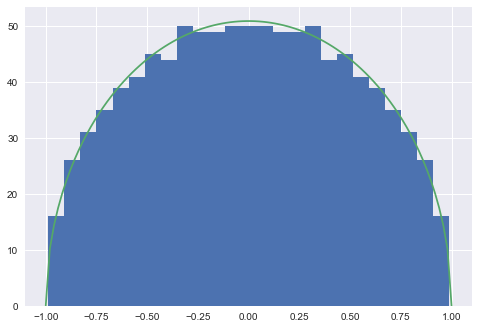

In [51]:
n = 1000
A = sample_antisymmetric(n)

l = np.linalg.eigvalsh(1j*A)
nbins = 25
plt.hist(l,nbins)

t = np.linspace(-1,1,100)
# the pdf of the eigenvalue distribution is 2*sqrt(1-t**2) / np.pi
pdf = 2 * np.sqrt(1-t**2) / np.pi
# to match the histogram, we need to normalize properly.
# The sum of the heights of the bins is n, and there are nbins
# So the integral of the histogram is 2 * n / nbins (since the domain is [-1,1])
plt.plot(t, pdf * 2 * n / nbins)
plt.show()

We've now numerically checked that the eigenvalues of $A$ follow a semicircle law.  What we will be concerned with in this notebook is trying to prove this.  My understanding is that this is usually done by computing moments of the distribution $\mathbf{E} \,\mathrm{trace}\,((iA)^k)$ or (more robustly) by computing the Stieltjes transform $s(A) = \mathrm{trace} (A-z)^{-1}$.  

I wanted instead to try to understand $\mathrm{trace} (e^{tA})$, which corresponds to the Fourier transform of the probability density.  What we will see in this notebook is that this appears to be related to a discrete one-dimensional wave equation.

My favorite way of thinking about the matrix $e^{At}$ is as the solution operator to the differential equation

$$
\dot{y}= Ay.
$$

That is, $e^{tA}x_0$ is the solution to the above equation with initial condition $y(0) = x_0$ evaluated at time $t$.  
Because $A$ is antisymmetric, the above equation is very special because it a couple of useful conservation laws.  This is related to the fact that $e^{At}$ is an orthogonal matrix, since 

$$
(e^{tA})^T = e^{tA^T} = e^{-tA} = (e^{tA})^{-1}.
$$

But we can also just write down the conserved quantities $y^Ty$ and $-y^TA^2y$ and compute derivatives.  
For the length $y^Ty$, we compute

$$
\frac{d y^Ty}{dt} = y^TA^Ty + y^TAy = 0.
$$

Similarly for the energy $-y^TA^2y$ we have

$$
-\frac{d y^TA^2y}{dt} = -y^TA^TA^2y - y^TA^2A^Ty = 0.
$$

The length invariant says that the trajectory of $y$ stays on the sphere, and the energy invariant says that its speed is constant.  The invariance of length and the linearity of $e^{At}$ ensures that $e^{At}$ is a rotation. 

Let's play with this numerically.

In [25]:
# let's set some simple initial condition.  
x0 = np.zeros(n)
x0[0] = 1

# compute the initial length and speed^2
length0 = np.dot(x0,x0)
energy0 = np.dot(np.dot(A,x0),np.dot(A,x0))

# we'll now solve $dy/dt = Ay$ using a simple forward Euler discretization 
y = x0
T = 5
dt = 1e-4
t = 0
while t < T:
    t += dt
    y = y + dt * np.dot(A,y)

# let's check that the invariants were conserved
lengthT = np.dot(y,y)
energyT = np.dot(np.dot(A,y),np.dot(A,y))

print "Initial and final length:", length0, lengthT
print "Initial and final energy:", energy0, energyT

# there is also a more direct way of checking that $e^{At}$ is a rotation
expAT = scipy.linalg.expm(T*A)
np.set_printoptions(suppress=True)
print np.dot(expAT, expAT.T)[:5,:5]

Initial and final length: 1.0 1.00013831959
Initial and final energy: 0.27660378407 0.276674565879
[[ 1.  0. -0. -0. -0.]
 [ 0.  1. -0. -0. -0.]
 [-0. -0.  1.  0. -0.]
 [-0. -0.  0.  1. -0.]
 [-0. -0. -0. -0.  1.]]


Now let's get at $\mathbf{E}\,\mathrm{trace}(e^{tA})$.  For any orthonormal basis $x_1,\ldots,x_n$, we can write

$$
\mathrm{trace}(e^{tA}) = \sum_k x_k^T e^{tA} x_k.
$$

Since the law of $A$ is invariant to permutations, we have

$$
\mathbf{E}\, x_k^T e^{tA} x_k =\mathbf{E}\, x_0^Te^{tA} x_0,
$$

so in particular

$$
\frac{1}{n} \mathbf{E}\, \mathrm{trace}(e^{tA}) = \mathbf{E}\, x_0^T e^{tA} x_0.
$$

One way to interpret this manipulation is that we're only going to use diagonal element of $e^{tA}$ as an estimate for the trace.  

In any case, our quest to understand the distribution of eigenvalues of $A$ has led us to asking about the behavior
of $f(t) = y_0^Ty_t$ where $y$ is the solution to the random differential equation

$$
\dot{y} = Ay.
$$

That is, we are going to pick some point on the unit sphere (the north pole works fine) and randomly spin it.  As it 
spins we keep track of how far it strays from its initial position ($\|y_0-y_t\|^2 = 2 (1-y_0^Ty_t)$).  If we can understand the behavior of this as a function of $t$ then we can recover $\mathbf{E}\,\mathrm{trace}(e^{tA})$.  Observe in particular that we need to be able to understand $f(t)$ for a long time (where the time is allowed to depend on $n$ but should grow as $n$ grows).

Before analyzing the evolution of $f(t)$ we will see what it does numerically.  I will cheat a bit and encode the limiting answer in the 

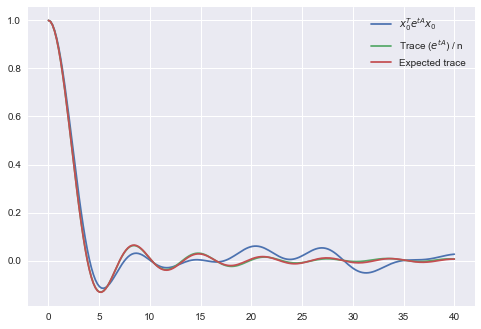

In [57]:
# our favorite initial condition
x0 = np.zeros(n)
x0[0] = 1

n = 1000
A = sample_antisymmetric(n)

# we will compare 3 things: 
#    1. the first diagonal element of e^{tA} (x_0^Te^{tA}x_0)
#    2. trace(e^{At}) / n
#    3. the exact solution J_1(t) / t

maxT = 40
nsteps = 200
t = np.linspace(0,maxT,nsteps)
dt = t[1] - t[0]
# the three quantities we will keep track of in the evolution
diagonal = np.zeros(nsteps)
trace = np.zeros(nsteps)
exact_bessel = np.zeros(nsteps)

# we need these to solve the differential equation to compute 1.
y = np.copy(x0)
propagator = scipy.linalg.expm(dt * A)

# we'll compute the trace using the eigenvalues so we don't have to compute e^{sA} 
# for all times s
l = np.linalg.eigvalsh(1j*A)

for k,s in enumerate(t):
    diagonal[k] = np.dot(x0, y)
    trace[k] = np.sum(np.cos(s*l)) / n
    if s > 0:
        exact_bessel[k] = 2 * scipy.special.j1(s) / s
    else:
        exact_bessel[0] = 1.
    
    y = np.dot(propagator, y)

plt.plot(t, diagonal, label="$x_0^Te^{tA}x_0$")
plt.plot(t, trace, label="Trace ($e^{tA}$) / n")
plt.plot(t, exact_bessel, label="Expected trace")
plt.legend()

plt.show()

From the plot we observe a few features.  First of all, the function $f(t) = y_0^Ty_t$ has a non-intuitive behavior (if your intuition, like mine, is based on low-dimensional rotations).  The vector $y_t$ quickly becomes orthogonal to $y_0$, which makes sense, but $y_0^Ty_t$ continues to oscillate around $0$ with a decreasing amplitude.

The second thing that is apparent from the plot is that $f(t)$ is actually quite a poor estimate of the expected trace (compared to, for example, the actual trace of $e^{tA}$).  Indeed, the trace appears to remain quite close to its expectation for time up to at least $t=40$.  However $f(t)$ diverges from the exact answer much more quickly.  We can 
however check that the reduction in variance from taking the trace is actually not more than what one would expect if 
each diagonal element of $e^{tA}$ were independent of each other.  Obviously, the diagonal elements are not independent, but we can just check that there doesn't seem to be additional spurious cancellations by looking at the magnitudes of the errors involved.

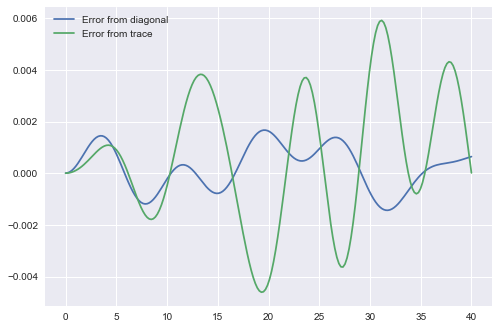

In [59]:
plt.plot(t, (diagonal-exact_bessel) / np.sqrt(n), label="Error from diagonal")
plt.plot(t, (trace - exact_bessel) , label="Error from trace")
plt.legend()
plt.show()

Now that we know what we're looking for, let's start to try to analyze the behavior of this function.  Now we will make the choice 

$$
x_0 = (1,0,0,\ldots),
$$

and split up the vector $y(t)$ into the first component and the rest of the vector

$$
y(t) = \left(\, f(t),\, z(t)\, \right)
$$

where $f(t)$ is the scalar function $f(t) = x_0^Ty(t)$.  The differential equation $\dot{y} = Ay$ now splits into coupled equations for $f$ and $z$

$$
\frac{df}{dt} = a_1^T z \qquad \frac{dz}{dt} = -a_1 \,f(t) + A^{(1)}z
$$

where we split $A$ into four blocks:

$$
A = 
\left(
\begin{align} 0 \quad& a_1^T \\ -a_1 \quad& A^{(1)} \end{align} 
\right).
$$

Here $a_0$ is a $(n-1)\times 1$ column matrix and $A^{(1)}$ is a square $(n-1)\times(n-1)$ matrix.  This splitting doesn't help us very much directly, but it does suggest a change of basis that makes our problem just a little bit simpler.  Observe that the only way that $z$ affects $f$ is via $a^Tz$, so the part of $z$ that is perpendicular to $f$ is uncoupled.  We are therefore prompted to write

$$
z = g_1 \hat{a}_1 + z_2
$$


where $\hat{a} = a / \|a\|$ is the unit vector in the direction of $a$, and $z_2^T a = 0$.  This induces the splitting
$$
A = 
\left(
\begin{align} 
0 & \quad\|a_1\| & 0 \\ 
-\|a_1\|&  \quad 0 & a_2^T \\
0 & \quad -a_2 & A^{(2)}
\end{align} 
\right).
$$


then we have

$$
\begin{align}
\frac{df}{dt} &= \|a_1\|\,\, g_1 \\
\frac{dg_1}{dt} &= -\|a_1\|\,\, f + a_2^T z_2 \\
\frac{dz_2}{dt} &= -a_2 \, g_1 + A^{(2)}z_2.
\end{align}
$$

To get here we had to perform a change of basis that mapped the vector $(0,1,0,\ldots,0)$ into the vector $(0,\hat{a}_1)$ 
and vice versa.  This can be implemented with a Householder reflection, which we'll describe below.  There are two important facts about this reflection (which we'll denote by $Q_1$):

1. It is an orthogonal matrix.
2. As random variables, the entries of $Q_1$ are independent of the entries in $A^{(1)}$.

Because we chose $A$ to be an antisymmetric matrix with independent Gaussian entries, this ensures that the elements
of the vector $a_2$ and the matrix $A{(2)}$ remain independent and identically distributed Gaussians.

To make this reflection $Q_1$, let's first remind ourselves how Householder reflections work.  A Householder reflection is a reflection about a hyperplane perpendicular to a unit vector $v$.  What it should do is keep any vector perpendicular to $v$ constant, and map $v$ to $-v$.  This is accomplished with the matrix

$$
Q_v = I - 2 vv^T.
$$

Observe that $Q_v = Q_v^T$ and $Q_v^2 = I$ (assuming $\|v\|^2=1$), so this really is a reflection.  To make our desired reflection $Q_1$ we want to reflect about the plane perpendicular to the vector 

$$
v = (0,1,\ldots) - (0,\hat{a}_1).
$$

Let's implement this reflection numerically and check that it simplifies the matrix $A$ as desired.


In [66]:
n = 1000
A = sample_antisymmetric(n)

# the first row of A
a1 = A[0,:]
a1hat = a1 / np.linalg.norm(a1)

# the vector we want to reflect it to
b = np.zeros(n)
b[1] = 1

# the vector perpendicular to our reflection plane
v = (a1hat - b)
v = v / np.linalg.norm(v)

# the Householder reflection
Q = np.eye(n) - 2 * np.outer(v,v)

# our new A, with the change of basis
A_reflected = np.dot(Q,np.dot(A, Q.T))

np.set_printoptions(suppress=True)
print "Length of row a1: ", np.linalg.norm(a1)
print "Reflected matrix A:"
print A_reflected[:5,:5]
print 
print "Reflection matrix Q:"
print Q[:5,:5]

Length of row a1:  0.495569264699
Reflected matrix A:
[[ 0.          0.49556926 -0.         -0.         -0.        ]
 [-0.49556926 -0.         -0.0013508  -0.01422527  0.00487541]
 [ 0.          0.0013508  -0.         -0.00684041 -0.00021975]
 [ 0.          0.01422527  0.00684041 -0.         -0.01108247]
 [ 0.         -0.00487541  0.00021975  0.01108247  0.        ]]

Reflection matrix Q:
[[ 1.          0.          0.          0.          0.        ]
 [ 0.          0.01307195 -0.00048513  0.03533377  0.04110408]
 [ 0.         -0.00048513  0.99999976  0.00001737  0.0000202 ]
 [ 0.          0.03533377  0.00001737  0.99873499 -0.0014716 ]
 [ 0.          0.04110408  0.0000202  -0.0014716   0.99828808]]


We can see then that the Householder reflection does actually introduce a lot of zeros in the matrix $A$.  What is especially nice about $Q$ is that it keeps the vector $x_0$ constant, so performing this change of coordinates does not affect the evolution of our quantity $f(t)$ which tells us about the trace.  

Moreover, it is easy to compute the law of the entry $\|a_1\|$, since it is the square root of the sum of squares of independent Gaussian entries.  Since each entry has variance $\frac{1}{4n}$, and there are $n-1$ entries in the row
we compute

$$
\mathbf{E} \, \|a_1\|^2 = \frac{n-1}{4n}. 
$$

When $n$ is large the random variable $\|a_1\|^2$ will be concentrated around this quantity, so we can in fact say that

$$
\|a_1\| \approx \frac{1}{2}\sqrt{\frac{n-1}{n}}
$$

with high probability.  Now we can iterate the process of reflecting the basis and introducing zeros.  It is only easy to compute the rest of the diagonal entries in the independent Gaussian case, where we observe that the law of the entries remains unchanged.  What we should see is that the $k$-th entry above the diagonal, $\|a_k\|$, has expectation

$$
\|a_k\| \approx \frac{1}{2} \sqrt{\frac{n-k}{n}}.
$$

Below we confirm that this holds in a numerical example.  Rather than write code to perform the iterative Householder reflections, we can make use of `scipy.linalg.hessenberg` function.  This performs an orthogonal change of coordinates that ensures that the matrix is upper Hessenberg -- that is, that it has zeros at every entry at least 2 below the diagonal.  Since our matrices are also anti-symmetric the Hessenberg factorization will necessarily tridiagonalize the matrix.  The algorithm that does this factorization does exactly a sequence of Householder transformations, just faster and easier than our own implementation would be.  One caveat is that it will not necessarily respect our desire to have positive entries above the diagonal and negative entries below, but we can easily swap those by conjugating with a diagonal matrix of $\pm 1$ values.

In [78]:
def sample_uniform_entries(n):
    A = (np.random.rand(n,n)-0.5) * np.sqrt(6) / np.sqrt(n)
    return (A-A.T)/2

def sample_bernoulli_entries(n):
    coins = np.random.randint(2,size=n*n)
    A = (coins.reshape((n,n))-0.5) * np.sqrt(2) / np.sqrt(n)
    return (A-A.T)/2

In [80]:
def positive_hessenberg_factor(A):
    # compute the hessenberg factorization of an antisymmetric matrix A,
    # but and ensure that the entries above the diagonal are positive.
    H = scipy.linalg.hessenberg(A)
    x = np.abs(np.diag(H,1))
    return np.diag(x,1) - np.diag(x,-1)

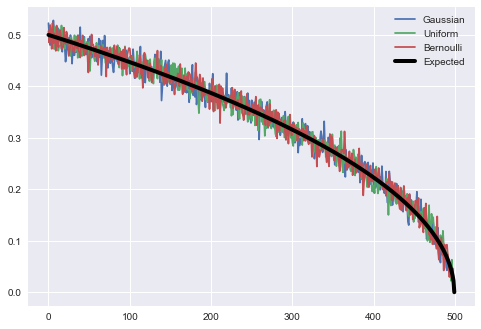

In [91]:
n = 500
# sample a few different matrices and perform Householder rotations 
# using scipy.linalg.hessenberg
A_gaussian = sample_antisymmetric(n)
A_uniform = sample_uniform_entries(n)
A_bernoulli = sample_bernoulli_entries(n)

H_gaussian = positive_hessenberg_factor(A_gaussian)
H_uniform = positive_hessenberg_factor(A_uniform)
H_bernoulli = positive_hessenberg_factor(A_bernoulli)

# and also make the tridiagonal matrix we expect to see, with
# entries \sqrt{(n-k)/n} / 2
ks = np.array(range(1,n+1), dtype=np.float)
a_norms = np.sqrt((n-ks)/n) / 2
H_computed = np.diag(a_norms, 1) - np.diag(a_norms,-1)

x_g = np.diag(H_gaussian, 1)
x_u = np.diag(H_uniform, 1)
x_b = np.diag(H_bernoulli, 1)
x_c = np.diag(H_computed, 1)

plt.plot(x_g, label="Gaussian")
plt.plot(x_u, label="Uniform")
plt.plot(x_b, label="Bernoulli")
plt.plot(x_c, c='k', lw=4, label="Expected")
plt.legend()
plt.show()

Now that we've tridiagonalized $A$, we can go back to understanding the function 

$$
f(t) = y_0^Ty_t = x_0^Te^{tA}x_0.
$$

Recall that this function did not depend on our choice of basis for the last $n-1$ coordinates of $y$, and that was enough freedom to tridiagonalize $A$.  Writing $\alpha_k$ for the $k$-th value above the diagonal and $g_k$ for the coefficients of the remaining $n-1$ coordinates of $y$ in the rotated coordinates, we have

$$
\begin{align}
\frac{df}{dt} &= \alpha_1 g_1 \\
\frac{dg_1}{dt} &= \alpha_2 g_2 - \alpha_1 f \\
\frac{dg_2}{dt} &= \alpha_3 g_3 - \alpha_2 g_1 \\
&\vdots \\
\frac{dg_k}{dt} &= \alpha_{k+1} g_{k+1} - \alpha_{k-1} g_{k-1} \\
&\vdots
\end{align}
$$

Suppose that we look at the first $k$ equations, and $k\ll n$.  Then we approximately have $\alpha_j = 1$ for 
$1\leq j\leq k$.  Then we can think of the vector $(f, g_1, g_2, \ldots)$ as a function $u$ with $u(j) = g_j$ for $j>0$ and $u(0) = f$.  We can then write this system as

$$
\dot{u} = Du
$$

where $Du$ is the central finite difference operator.  This looks like a transport equation, but because of the nature of the central differencing and the lack of smoothness in the initial condition the discrete equation does not behave as a transport equation.  The important fact here is that the derivatives of the even entries of $u$ depend on the odd entries, and vice versa.  That's a little tricky to think about but we can get an equation for the even entries in terms of only the even entries by taking a second derivative.  This yields the equation

$$
\ddot{u} = D^2u
$$

which looks like a wave equation (with a Dirichlet boundary condition on the left edge).  This more accurately describes the behavior of $u$, but it is tricky to try to think about this in terms of a continuum wave equation.  The reason is that the initial condition looks like a delta function at one edge of a vibrating string, but the boundary condition is that the edge of the string is fixed.  Also since the initial condition is not smooth it's not clear that it is accurate to think of the discrete differences as approximations of a finite difference. 

In any case, we can simulate the equation and see what the solutions look like.

In [120]:
n = 500
A = sample_antisymmetric(n)
H_random = positive_hessenberg_factor(A)
# convert to csr sparse matrix for fast (linear-time) matrix-vector application
H_random = scipy.sparse.csr.csr_matrix(H_random)

# compute the expected matrix sqrt((n-k)/n)
ks = np.array(range(1,n), dtype=np.float)
alphas = np.sqrt((n-ks)/n) / 2
H_computed = scipy.sparse.csr.csr_matrix(np.diag(alphas, 1) - np.diag(alphas, -1))

# finally, the limiting matrix of all 1/2
one_halfs = 0.5 * np.ones(n-1)
H_limit = scipy.sparse.csr.csr_matrix(np.diag(one_halfs,1) - np.diag(one_halfs,-1))

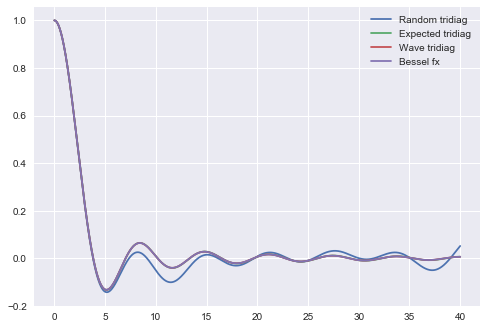

In [125]:
# now lets do some dynamics

x0 = np.zeros(n)
x0[0] = 1
# set up the initial conditions
xr = np.copy(x0)
xc = np.copy(x0)
xl = np.copy(x0)

# time discretization
T = 40
numsteps = 20000
t = np.linspace(0,T,numsteps)

# make propagators for each of our matrices
dt = t[1] - t[0]
prop_r = scipy.sparse.eye(n) + dt * H_random + dt**2 * H_random.dot(H_random) / 2
prop_c = scipy.sparse.eye(n) + dt * H_computed + dt**2 * H_computed.dot(H_computed) / 2
prop_l = scipy.sparse.eye(n) + dt * H_limit + dt**2 * H_random.dot(H_limit) / 2

fr = np.zeros(numsteps)
fc = np.zeros(numsteps)
fl = np.zeros(numsteps)
ftrue = np.zeros(numsteps)

for k,s in enumerate(t):
    fr[k] = np.dot(x0, xr)
    fc[k] = np.dot(x0, xc)
    fl[k] = np.dot(x0, xl)    
    if s > 0:
        ftrue[k] = 2 * scipy.special.j1(s) / s
    else:
        ftrue[0] = 1.
        
    xr = prop_r.dot(xr)
    xc = prop_c.dot(xc)
    xl = prop_l.dot(xl)

plt.plot(t, fr, label='Random tridiag')
plt.plot(t, fc, label='Expected tridiag')
plt.plot(t, fl, label='Wave tridiag')
plt.plot(t, ftrue, label='Bessel fx')
plt.legend()
plt.show()

From this plot we can verify that when we use the Hessenberg factorization of a random matrix we do recover the behavior of our earlier simulations of a vector randomly rotating on a sphere.  What is also interesting is that the tridiagonal matrices from the expected $\alpha_k$ and the constant $\alpha_k$ both do a great job of reproducing the same behavior.  In fact it is not clear which is better, so let's plot the errors just comparing those two.

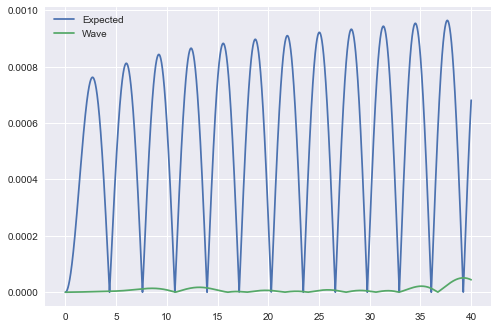

In [127]:
plt.plot(t, np.abs(fc-ftrue), label='Expected')
plt.plot(t, np.abs(fl-ftrue), label='Wave')
plt.legend()
plt.show()

From this plot we can see that it is indeeed the wave equation

$$
\ddot{u} = D^2 u 
$$

that has the correct limiting behavior.  I find this a bit strange since it does not have the correct distribution of eigenvalues.

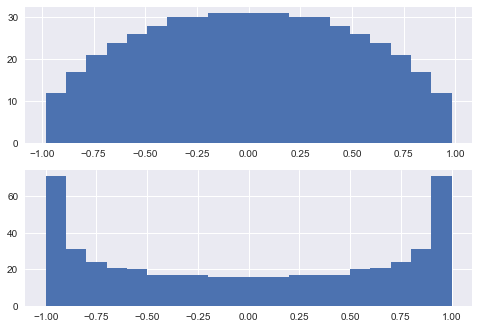

In [131]:
dense_expected = H_computed.todense()
dense_limit = H_limit.todense()

l_expected = np.linalg.eigvalsh(1j*dense_expected)
l_limit = np.linalg.eigvalsh(1j*dense_limit)

plt.subplot(2,1,1)
plt.hist(l_expected, 20)

plt.subplot(2,1,2)
plt.hist(l_limit, 20)
plt.show()

It is worth noting also that one reason it makes sense just to look at the first $k$ values of $\alpha_k$, with $k\ll n$, is that the equation $\dot{u} = Du$ has a finite speed of propagation, so it cannot tell what the later values of $\alpha$ are anyway.  We can check this by looking at the coefficients of $y_t$.

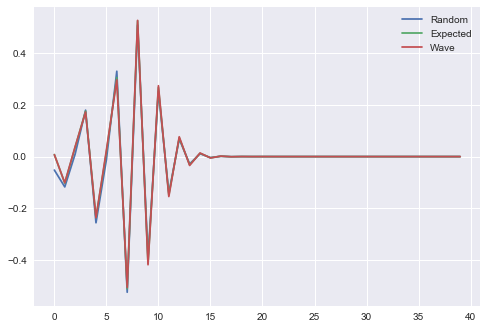

In [138]:
x0 = np.zeros(n)
x0[0] = 1
# set up the initial conditions
xr = np.copy(x0)
xc = np.copy(x0)
xl = np.copy(x0)

# time discretization
T = 10
numsteps = 400
t = np.linspace(0,T,numsteps)

# make propagators for each of our matrices
dt = t[1] - t[0]
prop_r = scipy.sparse.eye(n) + dt * H_random + dt**2 * H_random.dot(H_random) / 2
prop_c = scipy.sparse.eye(n) + dt * H_computed + dt**2 * H_computed.dot(H_computed) / 2
prop_l = scipy.sparse.eye(n) + dt * H_limit + dt**2 * H_random.dot(H_limit) / 2

for k,s in enumerate(t):
    xr = prop_r.dot(xr)
    xc = prop_c.dot(xc)
    xl = prop_l.dot(xl)

plt.plot(xr[:40], label='Random')
plt.plot(xc[:40], label='Expected')
plt.plot(xl[:40], label='Wave')
plt.legend()
plt.show()


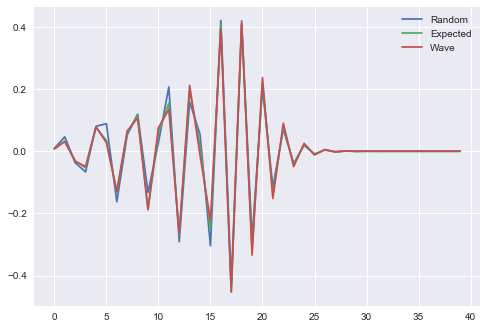

In [139]:
for k,s in enumerate(t):
    xr = prop_r.dot(xr)
    xc = prop_c.dot(xc)
    xl = prop_l.dot(xl)
    
plt.plot(xr[:40], label='Random')
plt.plot(xc[:40], label='Expected')
plt.plot(xl[:40], label='Wave')
plt.legend()
plt.show()

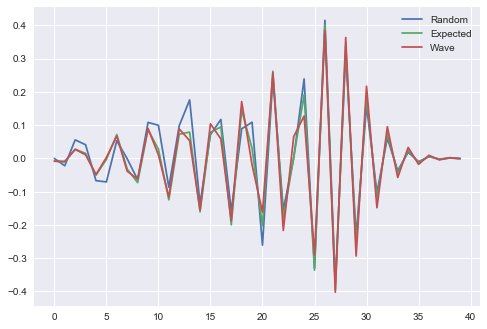

In [140]:
for k,s in enumerate(t):
    xr = prop_r.dot(xr)
    xc = prop_c.dot(xc)
    xl = prop_l.dot(xl)
    
plt.plot(xr[:40], label='Random')
plt.plot(xc[:40], label='Expected')
plt.plot(xl[:40], label='Wave')
plt.legend()
plt.show()

Here we've plotted the coefficients of $y$ at $t=10, 20, 30$.  Notice that the solution forms an outwardly propagating wave.  